In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# Define paths
train_data_dir = '/home/vipinainvijayan4286/Data/train'
test_data_dir = '/home/vipinainvijayan4286/Data/test'

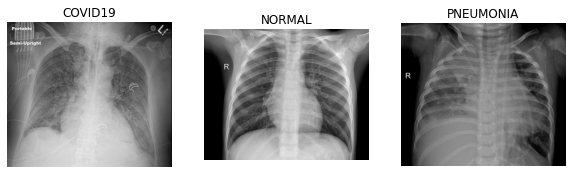

In [3]:
# Define base directory containing image folders
base_dir = '/home/vipinainvijayan4286/Data/train'

# Get all subdirectories
image_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Select random directories
num_images = 3  # Adjust the number as needed
random_indices = random.sample(range(len(image_dirs)), num_images)
selected_dirs = [image_dirs[i] for i in random_indices]

# Get random images and labels from each directory
selected_paths = []
selected_labels = []
for directory in selected_dirs:
  # Get image paths in the directory
  image_paths = [os.path.join(directory, image) for image in os.listdir(directory) if image.endswith((".jpg", ".jpeg", ".png"))]
  # Select a random image
  random_path = random.choice(image_paths)
  # Use directory name as label
  label = os.path.basename(directory)
  selected_paths.append(random_path)
  selected_labels.append(label)

# Display images with labels
plt.figure(figsize=(10, 5))
for i, (image_path, label) in enumerate(zip(selected_paths, selected_labels)):
  plt.subplot(1, num_images, i + 1)
  image = Image.open(image_path)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

In [4]:
# Define image parameters
img_height, img_width = 229, 229
batch_size = 32

In [5]:
# Create data generators with augmentation for training and without augmentation for testing
train_datagen = ImageDataGenerator(validation_split = 0.20,rotation_range=20,)

In [6]:
test_datagen = ImageDataGenerator(validation_split = 0.20,rotation_range=20,)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,subset='training',seed = 42
)

Found 4116 images belonging to 3 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,subset='training',seed = 42
)

Found 1031 images belonging to 3 classes.


In [9]:
# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [10]:
# Freeze the pre-trained layers
base_model.trainable = False

# Build your custom model on top of the pre-trained base model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))  # 3 output classes

In [11]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 4,378,278
Trainable params: 328,707
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
# Define an EarlyStopping callback instance with optimized parameters:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Track validation loss (or accuracy if preferred)
    patience=3,         # Wait for 5 epochs without improvement
    restore_best_weights=True,  # Restore best weights found so far
    min_delta=0.001,   # Consider improvement only if greater than 0.1%
    verbose=1          # Log messages during training
)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    epochs=9,
    verbose=1,
    validation_data=test_generator,
    callbacks=[early_stopping]    
)

Epoch 1/9
129/129 [==============================] - 961s 7s/step - loss: 0.3068 - accuracy: 0.8790 - val_loss: 0.1917 - val_accuracy: 0.9321
Epoch 2/9
129/129 [==============================] - 969s 8s/step - loss: 0.2047 - accuracy: 0.9169 - val_loss: 0.1765 - val_accuracy: 0.9399
Epoch 3/9
129/129 [==============================] - 972s 8s/step - loss: 0.1808 - accuracy: 0.9332 - val_loss: 0.1761 - val_accuracy: 0.9399
Epoch 4/9
129/129 [==============================] - 980s 8s/step - loss: 0.1555 - accuracy: 0.9410 - val_loss: 0.1651 - val_accuracy: 0.9370
Epoch 5/9
129/129 [==============================] - 976s 8s/step - loss: 0.1669 - accuracy: 0.9344 - val_loss: 0.1640 - val_accuracy: 0.9399
Epoch 6/9
129/129 [==============================] - 992s 8s/step - loss: 0.1486 - accuracy: 0.9427 - val_loss: 0.1705 - val_accuracy: 0.9399
Epoch 7/9
129/129 [==============================] - 1105s 9s/step - loss: 0.1401 - accuracy: 0.9463 - val_loss: 0.1603 - val_accuracy: 0.9457
Epoch

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", accuracy)

32/32 [==============================] - 196s 6s/step - loss: 0.1818 - accuracy: 0.9355
Test Accuracy: 0.935546875


In [16]:
model.save('/home/vipinainvijayan4286/ChestXray-Classification-App/model.h5')

/usr/local/anaconda/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


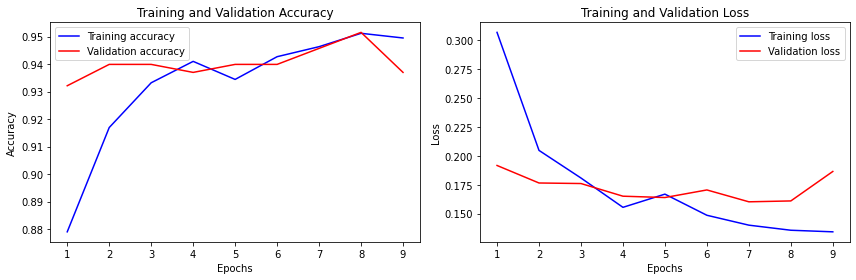

In [17]:
# Extracting training and validation metrics from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
test_generator = test_datagen.flow_from_directory(test_data_dir,target_size=(img_height, img_width),batch_size=32,shuffle=False,)


Found 1288 images belonging to 3 classes.


In [19]:
predictions=model.predict(test_generator)

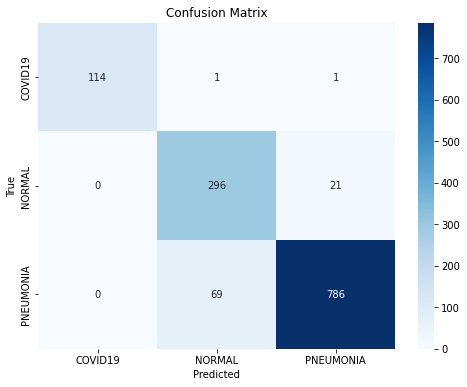

Classification Report:
               precision    recall  f1-score   support

     COVID19       1.00      0.98      0.99       116
      NORMAL       0.81      0.93      0.87       317
   PNEUMONIA       0.97      0.92      0.95       855

    accuracy                           0.93      1288
   macro avg       0.93      0.95      0.93      1288
weighted avg       0.93      0.93      0.93      1288



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Get true labels
true_labels = test_generator.classes

# Use the model to predict the classes
predicted_labels = np.argmax(model.predict(test_generator), axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

In [ ]:
# code for predicting an image stored locally against a trained model
# my local image is 28 x 28 already
import numpy as np
from PIL import Image
from keras.preprocessing import image
img = image.load_img('/home/vipinainvijayan4286/ChestXray-Classification-App/uploads/P.jpg',target_size = (229, 229))# , target_size=(32,32))
img  = image.img_to_array(img)
img  = img.reshape((1,) + img.shape)
# img  = img/255
#img = img.reshape(-1,229, 229,3)
img_class=model.predict(img) 
# this model above was already trained 
# code from https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-#neural-networks-python-keras/
prediction = img_class[0]
classname=list(test_generator.class_indices.keys())
print(classname[np.argmax(prediction, axis=0)])